In [31]:
import sys
import json
import string

import pandas as pd
import numpy as np

from random import randint, choice
from collections import Counter
from tqdm import tqdm
from collections import defaultdict
from nltk import ngrams
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix,  lil_matrix
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (16, 4)
STOP_WORDS = stopwords.words('english')

In [64]:
original_articles = pd.read_json('data/articles.json')
original_articles.set_index('article_id', inplace=True)
articles = (original_articles['Title'] + ' ' + original_articles['Content']).to_dict()

# Preprocessing

In [3]:
def preprocess(s):
    mapping = {c:' ' for c in string.punctuation.join(string.whitespace)}
    s = s.lower()
    s = s.translate(str.maketrans(mapping))
    return [word for word in s.split() if word not in STOP_WORDS]

## Extracting n-grams

In [4]:
def get_vocabulary(documents, n=2):   
    vocabulary = defaultdict(set)

    for doc_id, doc in tqdm(documents.items()):
        doc = preprocess(doc)
        shingles = ngrams(doc, n)
        for shingle in shingles:
            vocabulary[shingle].add(doc_id)
            
    return vocabulary

In [5]:
full_vocab = get_vocabulary(articles)
print(f'Full vocabulary contains {len(full_vocab)} distinct n-grams')

100%|██████████| 48505/48505 [00:34<00:00, 1404.92it/s]

Full vocabulary contains 4197134 distinct n-grams


In order to speed up the computation of the signature matrix, we discard all terms which appear only in a single document. As our goal is to find nearest duplicates among all documents, we can safely discard these terms as they do not help in finding similarities.

In [6]:
vocab = dict(filter(lambda x:len(x[1])>1, full_vocab.items()))
compression = len(vocab)/len(full_vocab)
print(f'Reduced vocabulary contains {len(vocab)} distinct n-grams ({compression:.1%} of original)')

Reduced vocabulary contains 1212935 distinct n-grams (28.9% of original)


# Building a term-document matrix

According to [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html), it's more efficient to build the sparse matrix incrementally using `lil_matrix`, and then convert it to `csr_matrix` for faster operations.


In [7]:
def binarize(vocabulary):
    documents = set.union(*vocabulary.values())
    binary_matrix = lil_matrix((len(vocabulary), max(documents)+1), dtype=bool)
    vocab_idx = {word:i for i, word in enumerate(vocabulary.keys())}

    for shingle, docs in tqdm(vocabulary.items()):
        for doc in docs:
            binary_matrix[vocab_idx[shingle], doc] = True

    return binary_matrix.tocsr()

In [8]:
bin_mat = binarize(vocab)
print(f'Binary matrix of shape {bin_mat.shape} with {bin_mat.nnz} true values')

100%|██████████| 1212935/1212935 [00:24<00:00, 49214.79it/s] 


Binary matrix of shape (1212935, 48505) with 8089485 true values


# Computing hash function values

In [9]:
def hash_matrix(n_rows, n_hash):
    hash_mat = np.empty((n_rows, n_hash), dtype=int)
    for column in tqdm(range(n_hash)):
        rand = randint(1, sys.maxsize)
        hash_mat[:, column] = (np.arange(n_rows) * rand) % n_rows
        #hash_val = int(sha256(str(row).encode()).hexdigest(), 16)
        #hash_mat[:, column] = (hash_val ^ rand) % len(vocab)
    return hash_mat

In [10]:
TOTAL_HASH = 1000
hash_mat = hash_matrix(len(vocab), TOTAL_HASH)
print(f'Hash matrix of shape {hash_mat.shape}')

100%|██████████| 1000/1000 [00:18<00:00, 54.08it/s]

Hash matrix of shape (1212935, 1000)


# Computing minhash signature matrix

Computing the signature matrix is the most expensive operation of the algorithm. In order to speed up testing, we compute it only once with a signature row of size 1000, so that we can later trunctate it to lower signature size if we do not need that much information.

In [11]:
def min_hash(binary_matrix, hash_matrix):
    n_hash = hash_matrix.shape[1]
    n_docs = binary_matrix.shape[1]
    n_words = binary_matrix.shape[0]
    max_val = binary_matrix.shape[0] + 1
    signature_matrix = np.full((n_hash, n_docs), max_val, dtype=np.int)

    for row in tqdm(range(n_words)):
        mask = (binary_matrix[row, :] == True).toarray()[0]
        signature_matrix[:, mask] = np.minimum(signature_matrix[:, mask], hash_matrix[row, :].reshape(-1, 1))
                    
    return signature_matrix

In [12]:
signature = min_hash(bin_mat, hash_mat)
print(f'Signature of shape {signature.shape}')

100%|██████████| 1212935/1212935 [06:33<00:00, 3084.85it/s]

Signature of shape (1000, 48505)


## Hash signature bands into buckets. Find a way to combine all the signature values in a band and hash them into a number of buckets ususally very high.
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before

In [13]:
def get_buckets(signature_matrix, row_per_band):
    n_bands = signature_matrix.shape[0] // row_per_band
    n_documents = signature_matrix.shape[1]
    buckets = defaultdict(set)
    
    for doc in tqdm(range(n_documents)):
        for i in range(n_bands):
            band_signature = ''.join(map(str, signature_matrix[i*row_per_band:(i+1)*row_per_band, doc]))
            band_signature = hash(band_signature)
            buckets[band_signature].add(doc)
   
    return buckets

In [14]:
SIG_SIZE = 100
ROW_PER_BAND = 2
buckets = get_buckets(signature[:SIG_SIZE, :], ROW_PER_BAND)

100%|██████████| 48505/48505 [00:07<00:00, 6239.65it/s]


# Hyperparameter tuning

We plot the probability of two documents falling in the same bucket for different similarities, signature sizes and number of bands.

In [15]:
def plot_proba():
    fig, ax = plt.subplots(1, 4)
    ax[0].set(xlabel='s', ylabel='P(same bucket)')
    sim = np.linspace(0.3, 1, num=100)
    for i, sig_size in enumerate([1, 10, 100, 1000]):
        for row_per_band in [1, 3, 5, 10]:
            n_bands = sig_size // row_per_band
            prob = 1 - (1 - pow(pow(sim, row_per_band), n_bands))
            ax[i].plot(sim, prob, label=f'b = {n_bands}')
            ax[i].set(title=f'signature size = {sig_size}')
        ax[i].legend()

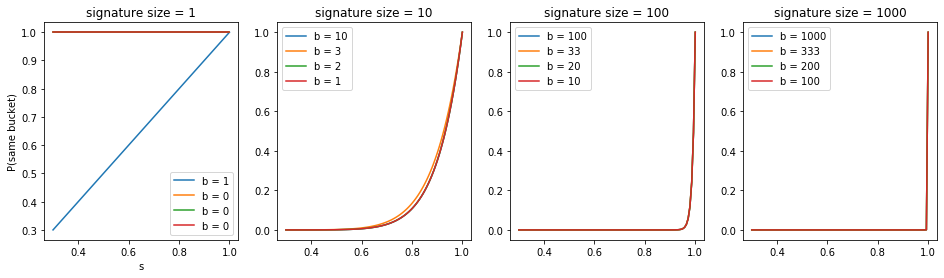

In [16]:
plot_proba()

## Choose the best parameters and get nearest neighbors of each articles

In [48]:
def get_neighbours(buckets):
    neighbours = {}
    
    # accumulate neighbours for each bucket
    for bucket in tqdm(buckets.values()):
        for doc in bucket:
            if doc in neighbours:
                neighbours[doc] += Counter(bucket)
            else:
                neighbours[doc] = Counter(bucket)

    # keep only neighbours appearing in more than one bucket
    for doc in neighbours:
        similar_docs = filter(lambda x: x[0] != doc and x[1] > 1, dict(neighbours[doc]).items())
        neighbours[doc] = list(_[0] for  _ in similar_docs)
    
    return neighbours

In [49]:
n = get_neighbours(buckets)

100%|██████████| 1523724/1523724 [00:16<00:00, 90530.16it/s] 


In [50]:
def submit(neighbours):
    with open('submissions.csv', 'w') as f:
        for doc_id, similar_docs in sorted(neighbours.items()):
            f.write(str(doc_id))
            other_docs = ',' + ','.join(str(d) for d in similar_docs) + '\n'
            f.write(other_docs)

In [51]:
submit(n)

# Testing the results

In [82]:
def print_neighbours(neighbours, min_similar = 2):
    similar_articles = []
    while len(similar_articles) < min_similar:
        similar_articles = choice(neighbours)
    return original_articles.loc[similar_articles]

In [98]:
print_neighbours(n,  5)

,Title,Content
article_id,,
16322,AAA reports Missouri gas prices lowest in country,"JEFFERSON CITY, Mo. (AP) — AAA says Missourian..."
1579,AAA reports Missouri gas prices lowest in country,"JEFFERSON CITY, Mo. (AP) - AAA says Missourian..."
33837,AAA: Missouri has lowest gas prices in the US,AAA says Missourians on average are paying the...
26416,AAA reports Missouri gas prices lowest in coun...,"JEFFERSON CITY, Mo. — AAA says Missourians on ..."
37843,AAA reports Missouri gas prices lowest in country,"(JEFFERSON CITY, Mo., AP) — AAA says Missouria..."
31511,AAA reports Missouri gas prices lowest in coun...,"JEFFERSON CITY, Mo. — AAA says Missourians on ..."
19514,AAA reports Missouri gas prices lowest in country,AAA reports Missouri gas prices lowest in coun...
4410,Kansas gas prices among lowest in the country,"JEFFERSON CITY, Mo. (AP) — AAA says Missourian..."
46670,Midwest Gas Prices Lowest In Country,AAA says Missourians on average are paying the...
